In [60]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive/HỌC KÌ DOANH NGHIỆP/'

Mounted at /content/gdrive


In [61]:
pip install wordcloud matplotlib

In [62]:
!pip install underthesea

In [63]:
!pip install -U sentence-transformers

In [64]:
!pip install wordcloud

#Import file data đã crawl

In [65]:
import json
import pandas as pd

# Đường dẫn đến file JSONL trên Google Drive
file_path = folder + '/Viettel_Clustering/viettel_scrape_new.jsonl'

# Đọc file JSONL
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Chuyển đổi danh sách dữ liệu thành DataFrame
df = pd.DataFrame(data)

# In thông tin của DataFrame
print(df.info())

print(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_name   305 non-null    object
 1   user_link   305 non-null    object
 2   name_group  245 non-null    object
 3   group_link  245 non-null    object
 4   time_post   305 non-null    int64 
 5   content     305 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.4+ KB
None
                              user_name  \
0    Viettel GroupTài khoản đã xác minh   
1                      Tin tức Việt Nam   
2                       Viettel Telecom   
3                         Viettel Group   
4                      Viettel Lai Châu   
..                                  ...   
300                            Long Bùi   
301                    Nguyễn Đức Cường   
302                 Tâm Nghiêm Thị Minh   
303                 Tâm Nghiêm Thị Minh   
304                 Tâm Nghiêm Thị Minh   

   

In [66]:
#Chuyển định dạng cột time_post sang datetime
df['time_post'] = pd.to_datetime(df['time_post'], unit='ms', errors='coerce')
print(df['time_post'])

0     2024-10-06
1     2024-10-07
2     2024-10-04
3     2024-10-05
4     2024-10-05
         ...    
300   2024-10-06
301   2024-10-03
302   2024-10-04
303   2022-10-07
304   2024-10-04
Name: time_post, Length: 305, dtype: datetime64[ns]


In [67]:
print(df)

                              user_name  \
0    Viettel GroupTài khoản đã xác minh   
1                      Tin tức Việt Nam   
2                       Viettel Telecom   
3                         Viettel Group   
4                      Viettel Lai Châu   
..                                  ...   
300                            Long Bùi   
301                    Nguyễn Đức Cường   
302                 Tâm Nghiêm Thị Minh   
303                 Tâm Nghiêm Thị Minh   
304                 Tâm Nghiêm Thị Minh   

                                             user_link  \
0    https://www.facebook.com/viettelgroupofficial?...   
1    https://www.facebook.com/tintucvietnammoinong?...   
2    https://www.facebook.com/vietteltelecom?__cft_...   
3    https://www.facebook.com/viettelgroupofficial?...   
4    https://www.facebook.com/@fanpage.viettellaich...   
..                                                 ...   
300  https://www.facebook.com/groups/35403766495382...   
301  https://www.fa

In [68]:
# Trích xuất cột 'content' thành một DataFrame mới
df_content = df[['content']]

#Xây dựng mô hình phân cụm

##Tiền xử lý

In [69]:
import nltk
nltk.download('punkt')
import pandas as pd
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from multiprocessing import Pool
from underthesea import word_tokenize
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
# Đọc stopwords
stopwords = set(open(folder + '/Viettel_Clustering/stopwords.txt', 'r', encoding='utf-8').read().split('\n')[:-1])
puct_set = set([c for c in '!"#$%&\'()*+,./:;<=>?@[\\]^`{|}~'])

# Hàm xóa HTML tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Hàm xóa icon (emoji)
def remove_icons(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Hàm loại bỏ stopwords
def remove_stopwords(text, stopwords):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

# Hàm xóa các kí tự là số
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Hàm tiền xử lý chính
def preprocessing(text):
    text = text.lower()  # Chuyển về chữ thường
    text = re.sub(r'[^\w\s]', '', text)  # Xóa dấu câu
    text = remove_html(text)  # Xóa HTML
    text = remove_icons(text)  # Xóa icon (emoji)
    text = remove_numbers(text)  # Xóa số
    text = remove_stopwords(text, stopwords)  # Xóa stopwords
    text = word_tokenize(text, format="text")  # Tách từ sử dụng underthesea
    text = ' '.join(text.split())  # Xóa khoảng trắng thừa
    return text

# Giả sử df_content đã được định nghĩa và có cột 'content'
documents = df_content['content'].tolist()

# Sử dụng multiprocessing để xử lý
pool = Pool(10)
clean_documents = pool.map(preprocessing, documents)
pool.close()
pool.join()

# Thêm cột đã được tiền xử lý vào DataFrame
df_content['cleaned_content'] = clean_documents

# In ra kết quả sau khi đã tiền xử lý
print(df_content[['content', 'cleaned_content']])


                                               content  \
0     Cùng khám phá người ảo siêu thực Vi An có khả...   
1     ĐẶC CÁCH TUYỂN DỤNG QUÂN NHÂN CHUYÊN NGHIỆP V...   
2     GIA ĐÌNH HAY SỰ NGHIỆP QUAN TRỌNG HƠN?-------...   
3     LẦN THỨ 7 LIÊN TIẾP VIETTEL GIỮ VỊ TRÍ #1 TRO...   
4     LẦN THỨ 7 LIÊN TIẾP VIETTEL GIỮ VỊ TRÍ #1 TRO...   
..                                                 ...   
300  𝐆𝐚𝐥𝐚𝐱𝐲 𝐒𝟐𝟒 𝐅𝐄 là “Một camera toàn năng = Thay ...   
301  INTERNET VIETTEL - LỰA CHỌN HOÀN HẢO CHO GIA Đ...   
302  Người Viettel có thể đăng ký tham dự Ngày hội ...   
303                                            Faiting   
304  Viettel held an official 5G opening event on O...   

                                       cleaned_content  
0    khám_phá ảo siêu_thực_vi_an khả_năng giao_tiếp...  
1    đặc tuyển_dụng quân_nhân chuyên_nghiệp đồng_ch...  
2    gia_đình_nghiệp quan_trọng_nghiệp quan_trọng đ...  
3    liên_tiếp vị_trí bxh_top công_ty công_nghệ_thô...  
4    liên_tiếp vị_

<ipython-input-70-448ec6a29ab3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['cleaned_content'] = clean_documents


In [71]:
print(df_content['cleaned_content'])

0      khám_phá ảo siêu_thực_vi_an khả_năng giao_tiếp...
1      đặc tuyển_dụng quân_nhân chuyên_nghiệp đồng_ch...
2      gia_đình_nghiệp quan_trọng_nghiệp quan_trọng đ...
3      liên_tiếp vị_trí bxh_top công_ty công_nghệ_thô...
4      liên_tiếp vị_trí bxh_top công_ty công_nghệ_thô...
                             ...                        
300    camera toàn_năng thay vạn ekip sở_hữu khả_năng...
301    internet lựa hoàn_hảo gia_đình chi_phí ktháng_...
302    thể đăng_ký tham_dự hội đi bệnh_nhân ung_thư c...
303                                              faiting
304    held an_official g opening event on october to...
Name: cleaned_content, Length: 305, dtype: object


##Feature Extraction TF-IDF

In [72]:
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict
import numpy as np

# Chuyển đổi nội dung thành vector TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_content['cleaned_content']).toarray()

##Phân cụm bằng Gaussian Mixture

In [73]:
# Sử dụng Gaussian Mixture Models để phân cụm
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

# Lấy nhãn cụm dự đoán
cluster_labels_gmm = gmm.predict(X)

# Tạo một OrderedDict để chứa các cụm cho Gaussian Mixture Model
res_cluster_gmm = OrderedDict()

# Sắp xếp dữ liệu vào các cụm dựa trên nhãn cụm từ GMM
for i in range(len(cluster_labels_gmm)):
    if cluster_labels_gmm[i] in res_cluster_gmm:
        res_cluster_gmm[cluster_labels_gmm[i]].append(i)
    else:
        res_cluster_gmm[cluster_labels_gmm[i]] = [i]

# Chuyển đổi OrderedDict thành danh sách và lọc các cụm có nhiều hơn 1 tài liệu
res_cluster_gmm = [res_cluster_gmm[i] for i in range(gmm.n_components) if i in res_cluster_gmm]
res_cluster_gmm = [sorted(r) for r in res_cluster_gmm if len(r) > 1]

# Sắp xếp các cụm theo kích thước, từ lớn đến nhỏ
res_cluster_gmm.sort(key=len, reverse=True)

# Tính toán số lượng tài liệu được phân cụm và số tài liệu không nằm trong cụm
num_documents = len(df_content['cleaned_content'])
num_clustered_documents_gmm = len([j for i in res_cluster_gmm for j in i])  # Số tài liệu được phân cụm
num_noise_documents_gmm = num_documents - num_clustered_documents_gmm  # Số tài liệu không nằm trong cụm (noise)

# In kết quả cho phương pháp Gaussian Mixture Models
print("=== Gaussian Mixture Models ===")
print("Number of clusters:", len(res_cluster_gmm))
print("Number of clustered documents:", num_clustered_documents_gmm)
print("Number of noise documents:", num_noise_documents_gmm)

=== Gaussian Mixture Models ===
Number of clusters: 3
Number of clustered documents: 305
Number of noise documents: 0


In [74]:
# In ra kết quả từng cụm từ GMM
for i, cluster in enumerate(res_cluster_gmm):
    print(f"GMM Cluster {i + 1} (Number of documents: {len(cluster)})")

    # Duyệt qua các chỉ số tài liệu trong cụm
    for idx in cluster:
        # Truy cập vào cột "cleaned_content" của DataFrame và in ra dòng đầu tiên
        print(df_content['cleaned_content'].iloc[idx].split('\n')[0])  # In ra dòng đầu tiên của văn bản

    print('\n')  # Dòng trống để ngăn cách giữa các cụm

# In ra các tài liệu thuộc noise
if num_noise_documents_gmm > 0:  # Kiểm tra số lượng tài liệu noise
    print("=== Noise Cluster ===")  # In ra cụm nhiễu (noise)

    # Duyệt qua các chỉ số tài liệu thuộc noise
    noise_indices = [i for i in range(num_documents) if i not in sum(res_cluster_gmm, [])]
    for idx in noise_indices:
        # Truy cập vào cột "cleaned_content" của DataFrame và in ra dòng đầu tiên
        print(df_content['cleaned_content'].iloc[idx].split('\n')[0])  # In ra dòng đầu tiên của văn bản

    print('\n')  # Dòng trống để ngăn cách
else:
    print("No documents in the noise cluster.\n")

GMM Cluster 1 (Number of documents: 193)
khám_phá ảo siêu_thực_vi_an khả_năng giao_tiếp diện_mạo nghiên_cứu phát triểnviettel vian
đặc tuyển_dụng quân_nhân chuyên_nghiệp đồng_chí nguyễn_đức_tài cứu sống bé gái thiên_taitrước vụ sạt_lở đất kinh_hoàng xảy rạng huyện bắc_mê hà_giang tuvong_thương giây_phút nguy_hiểm độ nguyễn_đức_tài đường đi ứng_cứu thông ngần_ngại lao cứu sống bé gái hành_động đồng_chí tài_thể_hiện phẩm_chất lính cụ hồ văn
gia_đình_nghiệp quan_trọng_nghiệp quan_trọng đôi giấc mơ ta vươn gia_đình tựa hi_sinh bao_bọc ta vấp ngã_thể tiếp_tục cố_gắng mai đôi_nghiệp giây_phút ta quên đi hiện_diện âm_thầm gia_đình mẹ
liên_tiếp vị_trí bxh_top công_ty công_nghệ_thông tinviễn thông uy_tín_việt namngày vinh_danh lễ công_bố top công_ty uy_tín ngành ngân_hàng bảo_hiểm công_nghệ nông_nghiệp công_nghệ vietnam_report phối_hợp báo vietnamnet tổ chứcđây liên_tiếp đầu bảng xếp_hạng top công_ty công_nghệ_thông viễn_thông uy_tín việt_nam bảng xế
liên_tiếp vị_trí bxh_top công_ty công_nghệ_t

###Word Cloud

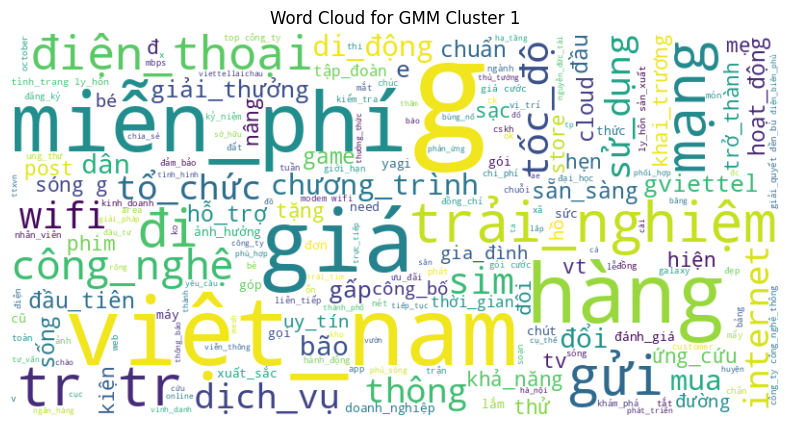

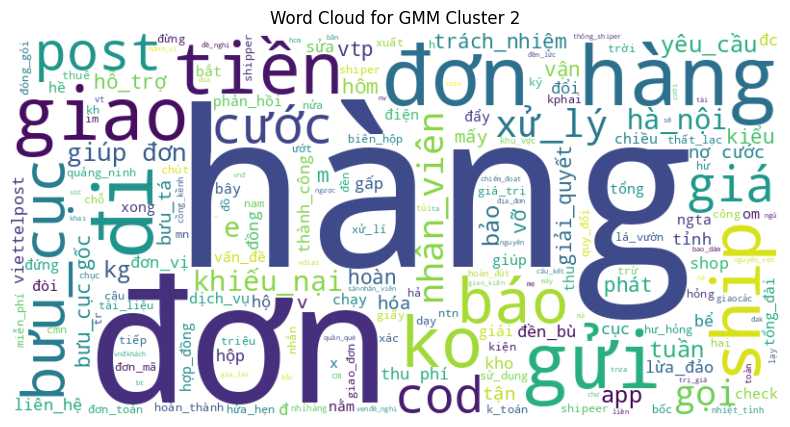

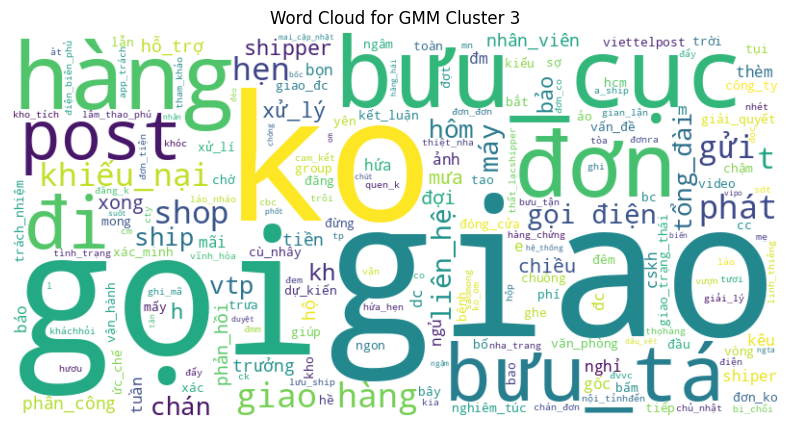

In [75]:
# Tạo Word Cloud cho từng cụm GMM
for i, cluster in enumerate(res_cluster_gmm):
    # Tạo một chuỗi văn bản từ tất cả các tài liệu trong cụm
    text = ' '.join(df_content['cleaned_content'].iloc[idx] for idx in cluster)

    # Tạo Word Cloud cho cụm
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Hiển thị Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for GMM Cluster {i + 1}")
    plt.show()

# Tạo Word Cloud cho các tài liệu thuộc noise
noise_indices = [i for i in range(num_documents) if i not in sum(res_cluster_gmm, [])]
if noise_indices:  # Kiểm tra xem có tài liệu nào thuộc noise không
    text_noise = ' '.join(df_content['cleaned_content'].iloc[idx] for idx in noise_indices)

    # Tạo Word Cloud cho noise
    wordcloud_noise = WordCloud(width=800, height=400, background_color='white').generate(text_noise)

    # Hiển thị Word Cloud cho noise
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_noise, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for Noise Cluster")
    plt.show()

###Chỉ số Silhouette

In [76]:
from sklearn.metrics import silhouette_score

# Tính chỉ số Silhouette
silhouette_avg = silhouette_score(X, cluster_labels_gmm)

# In kết quả chỉ số Silhouette
print("=== Silhouette Score for GMM ===")
print("Silhouette Score:", silhouette_avg)

=== Silhouette Score for GMM ===
Silhouette Score: 0.03786140331069752


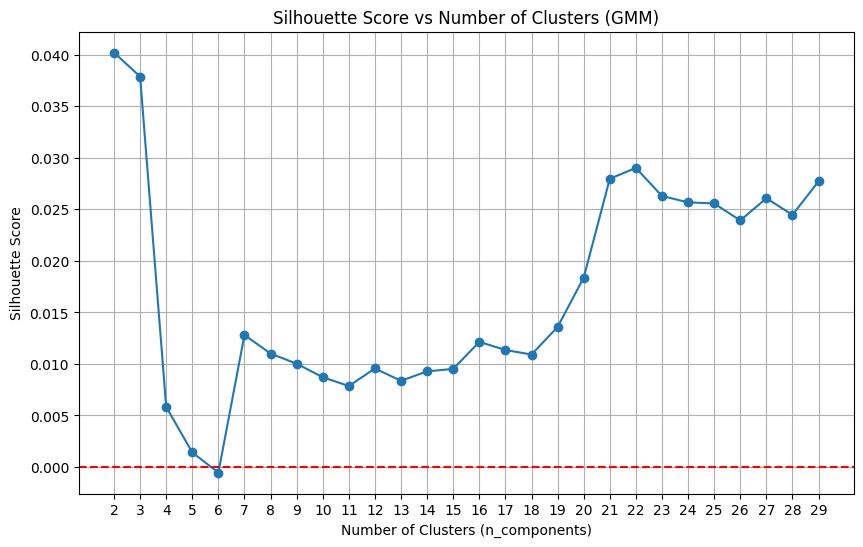

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Giả sử X là ma trận đặc trưng của tài liệu
silhouette_scores = []
num_components_range = range(2, 30)

for n_components in num_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels_gmm = gmm.fit_predict(X)

    # Tính chỉ số silhouette
    if len(set(cluster_labels_gmm)) > 1:
        silhouette_avg = silhouette_score(X, cluster_labels_gmm)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)  # Nếu chỉ có 1 cụm, chỉ số silhouette không hợp lệ

# Bước 2: Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(num_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (GMM)')
plt.xlabel('Number of Clusters (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(num_components_range)
plt.grid()
plt.axhline(0, color='red', linestyle='--')
plt.show()


##Phân cụm bằng DBSCAN

In [78]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from collections import OrderedDict

cleaned_documents = df_content['cleaned_content'].tolist()

# Sử dụng mô hình transformer pre-trained để lấy embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
document_embeddings = model.encode(cleaned_documents, convert_to_tensor=True)

# Sử dụng DBSCAN với ngưỡng epsilon (eps) và min_samples tùy chỉnh
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='cosine')
cluster_labels_dbscan = dbscan.fit_predict(document_embeddings)

# Tạo danh sách các cụm từ DBSCAN
res_cluster_dbscan = OrderedDict()
for idx, label in enumerate(cluster_labels_dbscan):
    if label in res_cluster_dbscan:
        res_cluster_dbscan[label].append(idx)
    else:
        res_cluster_dbscan[label] = [idx]

# Lọc và sắp xếp các cụm từ DBSCAN, bao gồm cả noise
clusters = [res_cluster_dbscan[label] for label in res_cluster_dbscan if label != -1]  # Loại bỏ noise
clusters = [sorted(r) for r in clusters]
clusters.sort(key=len, reverse=True)

# Noise cluster
noise_cluster = res_cluster_dbscan.get(-1, [])  # Các tài liệu bị coi là noise

# Tính toán số lượng tài liệu đã được phân cụm và số tài liệu không nằm trong cụm
num_clustered_documents_dbscan = len([j for i in clusters for j in i])  # Số tài liệu được phân cụm
num_noise_documents_dbscan = len(noise_cluster)  # Số tài liệu không nằm trong cụm (noise)

# Thêm nhãn cụm vào DataFrame
df_content['cluster_dbscan'] = cluster_labels_dbscan

# In kết quả cho phương pháp DBSCAN
print("\n=== DBSCAN với Transformer ===")
print("Number of clusters (excluding noise):", len(clusters))
print("Number of clustered documents:", num_clustered_documents_dbscan)
print("Number of noise documents:", num_noise_documents_dbscan)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



=== DBSCAN với Transformer ===
Number of clusters (excluding noise): 2
Number of clustered documents: 238
Number of noise documents: 67


<ipython-input-78-f98edfecd5d3>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['cluster_dbscan'] = cluster_labels_dbscan


In [79]:
# In ra kết quả từng cụm từ kết quả DBSCAN
for i in range(len(clusters)):
    print(f"DBSCAN Cluster {i + 1}")

    # Duyệt qua các chỉ số tài liệu trong cụm
    for idx in clusters[i]:
        # Truy cập vào danh sách 'cleaned_documents' và in ra dòng đầu tiên
        print(cleaned_documents[idx].split('\n')[0])

    print('\n')  # Dòng trống để ngăn cách giữa các cụm

# In ra các tài liệu thuộc noise (nếu có)
if len(noise_cluster) > 0:
    print("Noise Cluster")  # In ra cụm nhiễu (noise)

    for idx in noise_cluster:
        # Truy cập vào danh sách 'cleaned_documents' và in ra dòng đầu tiên
        print(cleaned_documents[idx].split('\n')[0])

    print('\n')  # Dòng trống để ngăn cách


DBSCAN Cluster 1
đặc tuyển_dụng quân_nhân chuyên_nghiệp đồng_chí nguyễn_đức_tài cứu sống bé gái thiên_taitrước vụ sạt_lở đất kinh_hoàng xảy rạng huyện bắc_mê hà_giang tuvong_thương giây_phút nguy_hiểm độ nguyễn_đức_tài đường đi ứng_cứu thông ngần_ngại lao cứu sống bé gái hành_động đồng_chí tài_thể_hiện phẩm_chất lính cụ hồ văn
gia_đình_nghiệp quan_trọng_nghiệp quan_trọng đôi giấc mơ ta vươn gia_đình tựa hi_sinh bao_bọc ta vấp ngã_thể tiếp_tục cố_gắng mai đôi_nghiệp giây_phút ta quên đi hiện_diện âm_thầm gia_đình mẹ
liên_tiếp vị_trí bxh_top công_ty công_nghệ_thông tinviễn thông uy_tín_việt namngày vinh_danh lễ công_bố top công_ty uy_tín ngành ngân_hàng bảo_hiểm công_nghệ nông_nghiệp công_nghệ vietnam_report phối_hợp báo vietnamnet tổ chứcđây liên_tiếp đầu bảng xếp_hạng top công_ty công_nghệ_thông viễn_thông uy_tín việt_nam bảng xế
liên_tiếp vị_trí bxh_top công_ty công_nghệ_thông tinviễn thông uy_tín_việt namngày vinh_danh lễ công_bố top công_ty uy_tín ngành ngân_hàng bảo_hiểm công_nghệ 

###Chỉ số Silhouette

In [80]:
# Tính chỉ số Silhouette
if len(set(cluster_labels_dbscan)) > 1:
    silhouette_avg_dbscan = silhouette_score(document_embeddings, cluster_labels_dbscan)
else:
    silhouette_avg_dbscan = -1  # Không đủ cụm để tính chỉ số

print("Silhouette Score:", silhouette_avg_dbscan)

Silhouette Score: 0.10444158


###Minh họa các văn bản gần tâm cụm


=== 3 tài liệu gần tâm nhất cho mỗi cụm DBSCAN ===

Cụm 0:
DKVN270924LINHA6: Đơn từ 27/10 đến nay, giục giao thì báo khả năng mất đơn, nhưng ko xử lý, shop hỏi...
------------
Đầu đuôi như này:m có gửi 1 đơn hàng Viettel Post VTP1763888797584Chỉ là một tờ giấy tài liệu thôi K...
------------
Khiếu nại lần 3: DKVN021024DUONG1:Gọi cả trưởng bưu cục phát lẫn trưởng bưu cục gốc: Ko thèm giao! T...
------------

Cụm 1:
 SIÊU PHẨM VIETTEL WIFI 6 – NÂNG CẤP TRẢI NGHIỆM INTERNET CỦA BẠN! 
 Tốc độ cao gấp 3 lần WiFi 5 – t...
------------
 VIETTEL CÀ MAU CHÍNH THỨC TRẢI NGHIỆM GÓI 5G TRÊN ĐỊA BÀN THÀNH PHỐ CÀ MAU ! Bạn đã sẵn sàng trải n...
------------
15.10.2024 Hà Nội checked-in: 5G VIETTEL 
Các bạn ơi, dịch vụ 5G đã chính thức được khai trương vào ...
------------

Cụm 2:
1.3₫
#Viettel 5G
------------

 #viettel #5G
------------
5.2₫
#Viettel 5G
------------


<ipython-input-87-43ccb3db91ed>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab10", len(set(cluster_labels_dbscan)))  # Chọn bảng màu


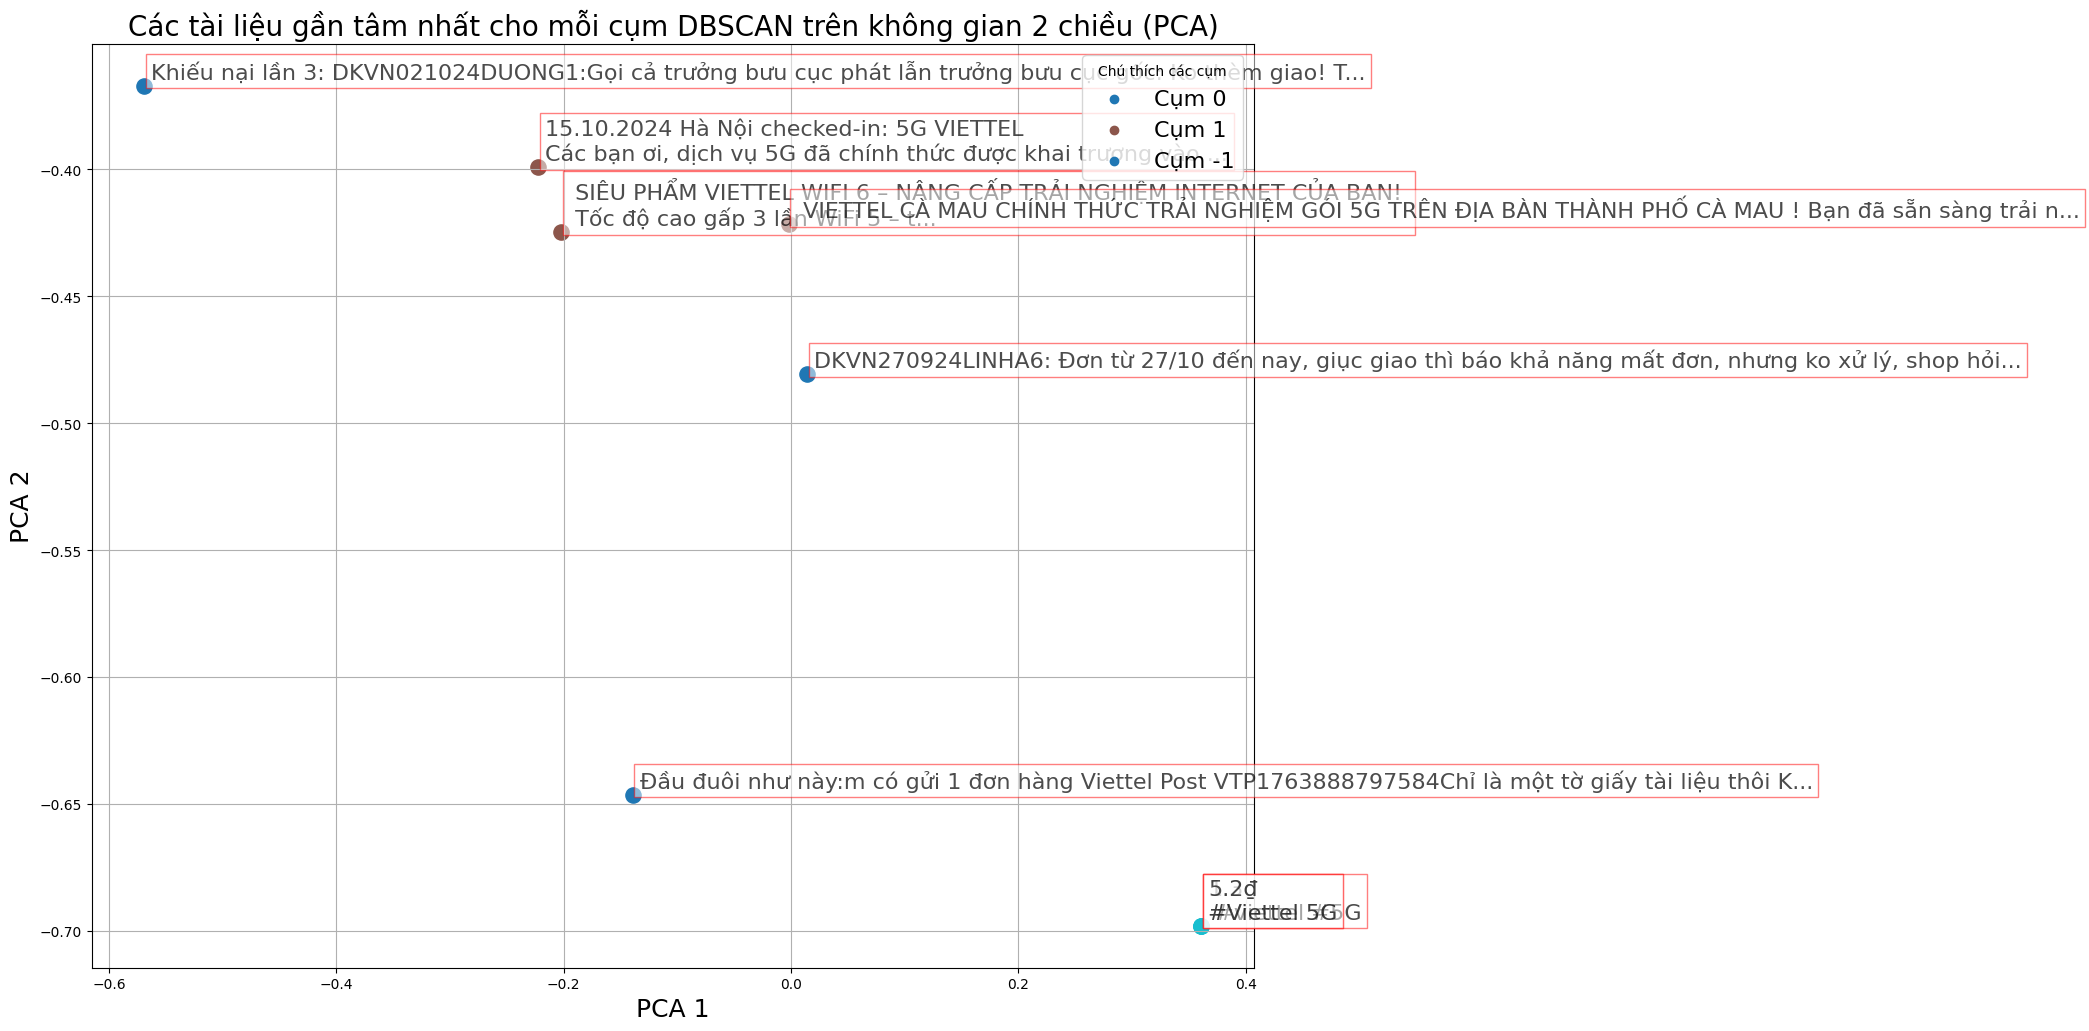

In [87]:
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Tìm 3 văn bản gần "tâm" nhất cho mỗi cụm DBSCAN
closest_docs_info = []  # Danh sách lưu thông tin về các tài liệu gần tâm nhất
print("\n=== 3 tài liệu gần tâm nhất cho mỗi cụm DBSCAN ===")
for cluster_idx, cluster_docs in enumerate(clusters):
    if len(cluster_docs) >= 3:
        # Lấy embeddings của các văn bản trong cụm hiện tại
        cluster_embeddings = document_embeddings[cluster_docs].cpu().numpy() if hasattr(document_embeddings, 'cpu') else document_embeddings[cluster_docs]

        # Tính ma trận khoảng cách của các văn bản trong cụm
        distance_matrix = pairwise_distances(cluster_embeddings, metric='cosine')

        # Tính khoảng cách trung bình đến các văn bản khác trong cùng cụm cho mỗi văn bản
        avg_distances = distance_matrix.mean(axis=1)

        # Tìm 3 văn bản có khoảng cách trung bình nhỏ nhất
        closest_indices = np.argsort(avg_distances)[:3]

        print(f"\nCụm {cluster_idx}:")
        for idx in closest_indices:
            doc_idx = cluster_docs[idx]
            # Lấy nội dung văn bản
            content = df_content['content'].iloc[doc_idx]
            # Kiểm tra độ dài nội dung
            if len(content) > 100:
                display_content = content[:100] + '...'  # Hiển thị 100 ký tự đầu và ba chấm
            else:
                display_content = content  # Hiển thị toàn bộ nội dung nếu ngắn hơn hoặc bằng 100 ký tự

            closest_docs_info.append((display_content, cluster_embeddings[idx], cluster_idx))
            print(display_content)
            print('------------')
    else:
        print(f"\nCụm {cluster_idx} có ít hơn 3 văn bản.")

# Giảm số chiều của embeddings xuống còn 2 chiều bằng PCA
pca = PCA(n_components=2)
document_embeddings_2d = pca.fit_transform(document_embeddings.cpu().numpy() if hasattr(document_embeddings, 'cpu') else document_embeddings)

# Vẽ biểu đồ chỉ với 3 tài liệu gần tâm nhất
plt.figure(figsize=(15, 12))  # Tăng kích thước hình

# Tạo bảng màu cho các cụm
colors = cm.get_cmap("tab10", len(set(cluster_labels_dbscan)))  # Chọn bảng màu

# Vẽ các tài liệu gần tâm nhất
for text, coords, cluster_idx in closest_docs_info:
    plt.scatter(coords[0], coords[1], color=colors(cluster_idx), s=120)  # Vẽ điểm theo màu cụm, tăng kích thước điểm
    plt.annotate(text, (coords[0], coords[1]), fontsize=16, alpha=0.7,  # Tăng kích thước chữ
                 xytext=(5, 5), textcoords='offset points',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='red'))

# Thêm chú thích cho các cụm
for cluster_idx in set(cluster_labels_dbscan):
    plt.scatter([], [], color=colors(cluster_idx), label=f'Cụm {cluster_idx}')

plt.title("Các tài liệu gần tâm nhất cho mỗi cụm DBSCAN trên không gian 2 chiều (PCA)", fontsize=20)  # Tăng kích thước tiêu đề
plt.xlabel("PCA 1", fontsize=18)  # Tăng kích thước chữ trục x
plt.ylabel("PCA 2", fontsize=18)  # Tăng kích thước chữ trục y
plt.legend(title='Chú thích các cụm', fontsize=16)  # Tăng kích thước chữ trong chú thích
plt.grid(True)
plt.show()


###Dendogram

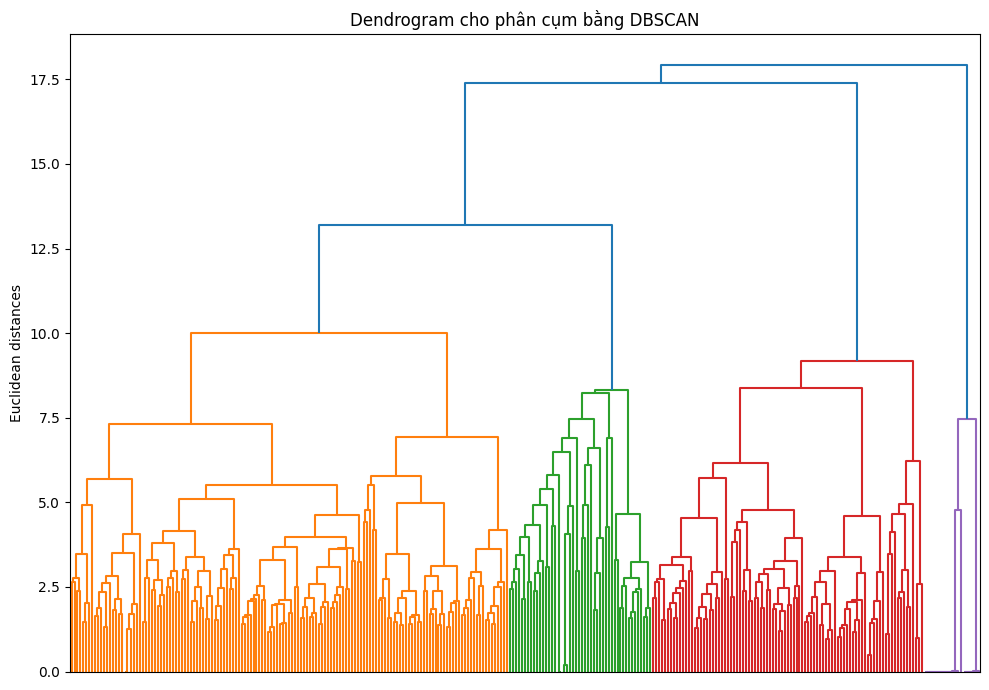

In [82]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Vẽ dendrogram
plt.figure(figsize=(10, 7))
linked = linkage(document_embeddings.cpu().numpy() if hasattr(document_embeddings, 'cpu') else document_embeddings, 'ward')  # Phân cụm phân cấp
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Ẩn nhãn của trục x
plt.title("Dendrogram cho phân cụm bằng DBSCAN")
plt.xlabel("")
plt.ylabel("Euclidean distances")
plt.xticks([])
plt.tight_layout()  # Điều chỉnh bố cục
plt.show()

###Word Cloud

DBSCAN Cluster 1


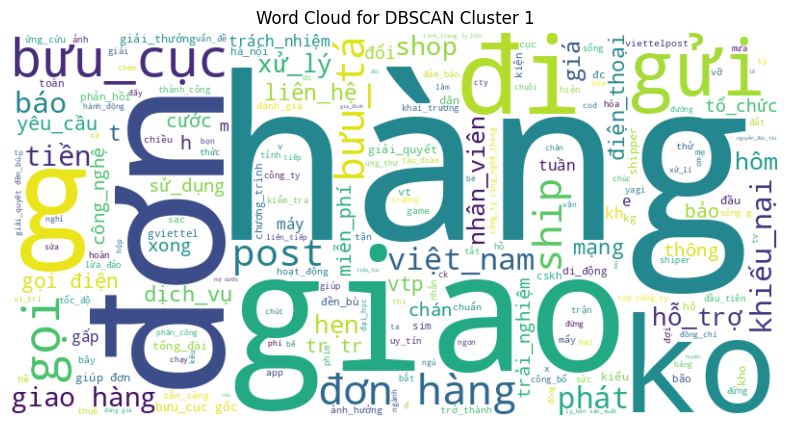

DBSCAN Cluster 2


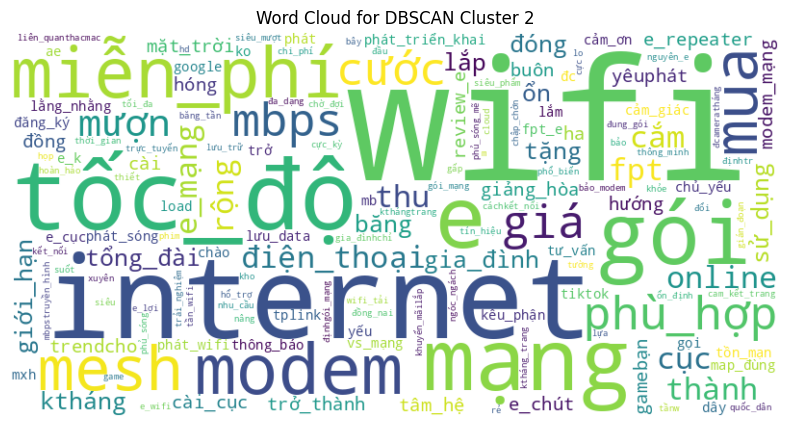

Noise Cluster


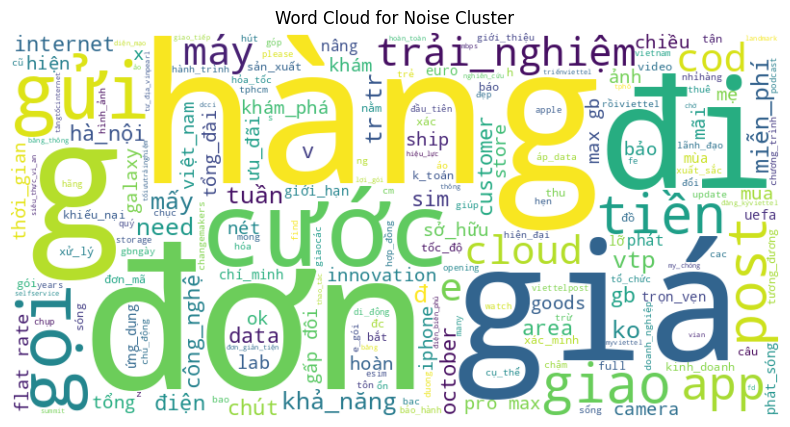

In [83]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Tạo Word Cloud cho từng cụm DBSCAN (không bao gồm noise)
for i in range(len(clusters)):
    print(f"DBSCAN Cluster {i + 1}")

    # Tạo một chuỗi văn bản từ tất cả các tài liệu trong cụm
    text = ' '.join(df_content['cleaned_content'].iloc[idx] for idx in clusters[i])

    # Tạo Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Hiển thị Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Không hiển thị trục
    plt.title(f"Word Cloud for DBSCAN Cluster {i + 1}")
    plt.show()

# Tạo Word Cloud cho các tài liệu thuộc noise
if len(noise_cluster) > 0:
    print("Noise Cluster")

    # Tạo một chuỗi văn bản từ tất cả các tài liệu thuộc noise
    text = ' '.join(df_content['cleaned_content'].iloc[idx] for idx in noise_cluster)

    # Tạo Word Cloud cho noise
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Hiển thị Word Cloud cho noise
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for Noise Cluster")
    plt.show()


##Phân cụm bằng BERT + Kmeans

In [84]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import OrderedDict

# Sử dụng mô hình BERT pre-trained để lấy embeddings
model = SentenceTransformer('bert-base-multilingual-cased')
document_embeddings = model.encode(clean_documents, convert_to_tensor=True)

# Sử dụng KMeans với số cụm tùy chỉnh
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels_kmeans = kmeans.fit_predict(document_embeddings)

# Tạo danh sách các cụm từ KMeans
res_cluster_kmeans = OrderedDict()
for idx, label in enumerate(cluster_labels_kmeans):
    if label in res_cluster_kmeans:
        res_cluster_kmeans[label].append(idx)
    else:
        res_cluster_kmeans[label] = [idx]

# Sắp xếp các cụm từ KMeans
clusters = [res_cluster_kmeans[label] for label in res_cluster_kmeans]
clusters = [sorted(r) for r in clusters]
clusters.sort(key=len, reverse=True)

# Tính toán số lượng tài liệu đã được phân cụm
num_clustered_documents_kmeans = len([j for i in clusters for j in i])

# In kết quả cho phương pháp KMeans
print("\n=== KMeans với BERT ===")
print("Number of clusters:", len(clusters))
print("Number of clustered documents:", num_clustered_documents_kmeans)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



=== KMeans với BERT ===
Number of clusters: 3
Number of clustered documents: 305


###Chỉ số Silhouette

Silhouette Score for KMeans: 0.061
Silhouette Score for 2 clusters: 0.309
Silhouette Score for 3 clusters: 0.061
Silhouette Score for 4 clusters: 0.067
Silhouette Score for 5 clusters: 0.082
Silhouette Score for 6 clusters: 0.089
Silhouette Score for 7 clusters: 0.065
Silhouette Score for 8 clusters: 0.095
Silhouette Score for 9 clusters: 0.094
Silhouette Score for 10 clusters: 0.092


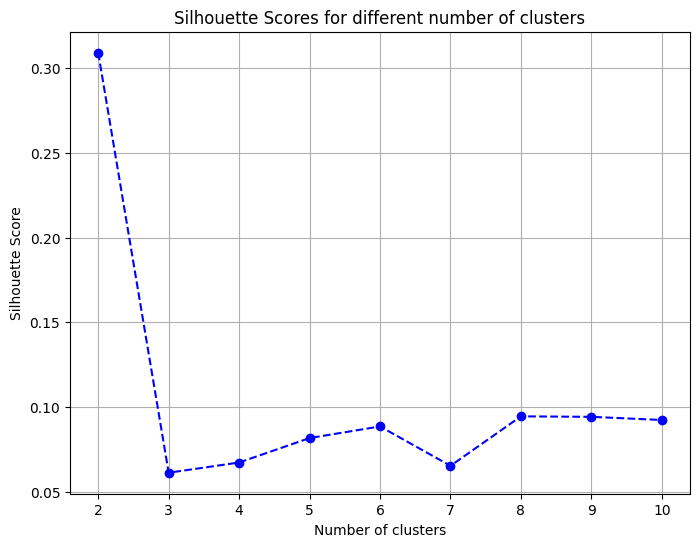

In [85]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Tính chỉ số silhouette cho các cụm từ KMeans
silhouette_avg = silhouette_score(document_embeddings.cpu(), cluster_labels_kmeans)
print(f"Silhouette Score for KMeans: {silhouette_avg:.3f}")

# Vẽ biểu đồ số cụm và chỉ số Silhouette cho từng số cụm
def plot_silhouette_scores(embedding_data, max_clusters=10):
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)

    for num_clusters in cluster_range:
        kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans_model.fit_predict(embedding_data.cpu())
        silhouette_avg = silhouette_score(embedding_data.cpu(), cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg:.3f}")

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='b')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for different number of clusters")
    plt.grid(True)
    plt.show()

# Gọi hàm để vẽ biểu đồ silhouette
plot_silhouette_scores(document_embeddings, max_clusters=10)


###Word Cloud


=== Word Cloud cho cụm 1 ===


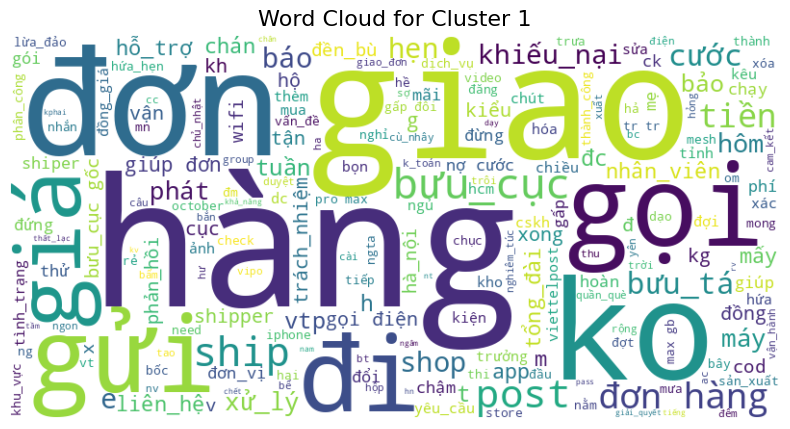


=== Word Cloud cho cụm 2 ===


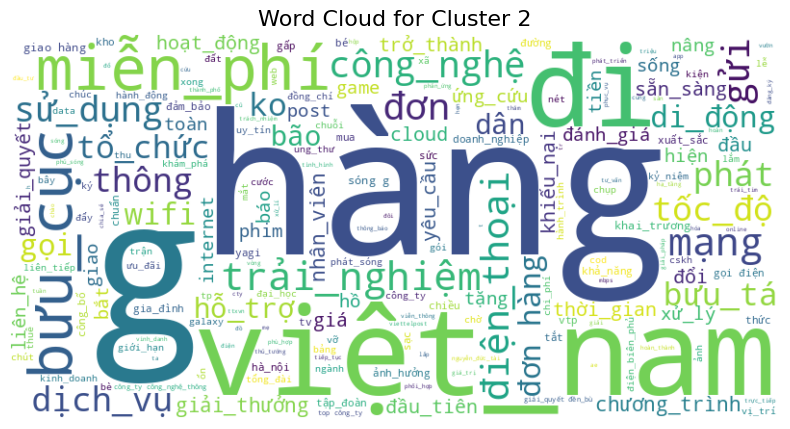


=== Word Cloud cho cụm 3 ===


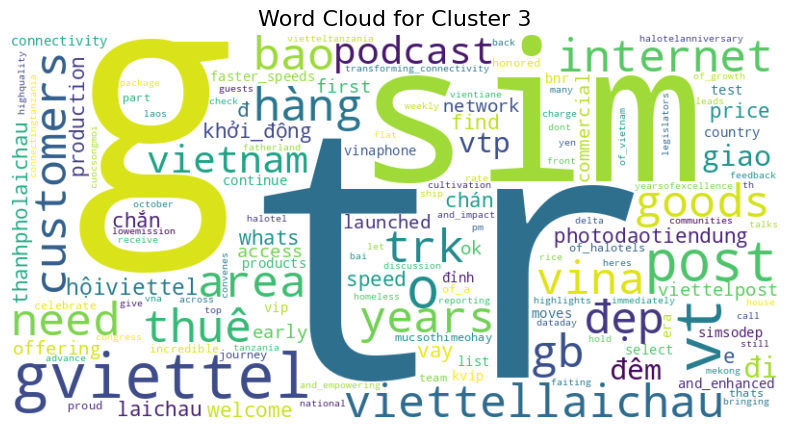

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo word cloud cho mỗi cụm
def plot_wordcloud_for_cluster(cluster_documents, cluster_id):
    # Ghép tất cả các tài liệu trong cụm thành một chuỗi
    cluster_text = ' '.join([clean_documents[i] for i in cluster_documents])

    # Tạo word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(cluster_text)

    # Vẽ word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}', fontsize=16)
    plt.show()

# Hiển thị word cloud
for cluster_id, cluster_documents in enumerate(clusters[:4]):
    print(f"\n=== Word Cloud cho cụm {cluster_id + 1} ===")
    plot_wordcloud_for_cluster(cluster_documents, cluster_id + 1)
